In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
import scipy.stats as st
import numpy as np

In [2]:
DATASET = "data2.txt"

### Analiza rzędu i rozmiaru sieci

In [3]:
multigraph_network = nx.read_edgelist(DATASET, create_using=nx.MultiGraph)
graph_network = nx.read_edgelist(DATASET, create_using=nx.Graph)

In [4]:
def print_graph_info(graph, graph_name):
    num_nodes = graph.number_of_nodes()
    num_edges = graph.number_of_edges()
    avg_degree = sum(dict(graph.degree()).values()) / num_nodes if num_nodes > 0 else "inf"
    
    print(f"{graph_name} Info:")
    print(f" - Number of nodes: {num_nodes}")
    print(f" - Number of edges: {num_edges}")
    print(f" - Average degree: {avg_degree:.4f}")
    print(f" - Is directed: {graph.is_directed()}")
    print(f" - Is multigraph: {graph.is_multigraph()}")

# Print info for each network
print_graph_info(multigraph_network, "MultiGraph Network")
print()
print_graph_info(graph_network, "Graph Network")

MultiGraph Network Info:
 - Number of nodes: 3425
 - Number of edges: 67663
 - Average degree: 39.5112
 - Is directed: False
 - Is multigraph: True

Graph Network Info:
 - Number of nodes: 3425
 - Number of edges: 19257
 - Average degree: 11.2450
 - Is directed: False
 - Is multigraph: False


In [5]:
print("MultiGraph selfloops")
print(nx.number_of_selfloops(multigraph_network))
print("Graph selfloops")
print(nx.number_of_selfloops(graph_network))

MultiGraph selfloops
1
Graph selfloops
1


In [6]:
graph_network.remove_edges_from(nx.selfloop_edges(graph_network))

In [7]:
print("Graph selfloops")
print(nx.number_of_selfloops(graph_network))

Graph selfloops
0


In [8]:
print_graph_info(graph_network, "Graph Network")

Graph Network Info:
 - Number of nodes: 3425
 - Number of edges: 19256
 - Average degree: 11.2444
 - Is directed: False
 - Is multigraph: False


### Największa składowa spójna

In [9]:
# Czy graf jest spójny
nx.is_connected(graph_network)

False

In [10]:
connected_components = list(nx.connected_components(graph_network))
largest_component = max(connected_components, key=len)
largest_subgraph = graph_network.subgraph(largest_component)

order = largest_subgraph.number_of_nodes()
size = largest_subgraph.number_of_edges()

print("Order:", order)
print("Size:", size)

Order: 3397
Size: 19230


### Aproksymacje średniej długości ściezki

In [11]:
import random

def average_shortest_path_length(G, num_samples):
    nodes = list(G.nodes())
    total_length = 0
    valid_pairs = 0

    while valid_pairs < num_samples:
        u, v = random.sample(nodes, 2)
        if nx.has_path(G, u, v):
            total_length += nx.shortest_path_length(G, u, v)
            valid_pairs += 1

    return total_length / valid_pairs


In [12]:
samples = [100, 1000, 10000]

for s in samples:
    avg = average_shortest_path_length(graph_network, s)
    print(f"Aproksymacja średniej długości ścieżki (dla {s} próbek): {avg:.2f}")

Aproksymacja średniej długości ścieżki (dla 100 próbek): 4.23
Aproksymacja średniej długości ścieżki (dla 1000 próbek): 4.10
Aproksymacja średniej długości ścieżki (dla 10000 próbek): 4.09


### Wyznaczanie liczby rdzeni o największym możliwym rzędzie

In [13]:
core_numbers = nx.core_number(graph_network)
unique_cores = sorted(set(core_numbers.values()), reverse=True)

In [14]:
three_largest_cores = unique_cores[0:3]

for i, core in enumerate(three_largest_cores):
    no_nodes = sum(1 for v in core_numbers.values() if v == core)
    print(f"{i + 1}. największy rząd rdzenia [{core}], liczba wierzchołków: {no_nodes}")

1. największy rząd rdzenia [31], liczba wierzchołków: 93
2. największy rząd rdzenia [30], liczba wierzchołków: 45
3. największy rząd rdzenia [29], liczba wierzchołków: 11


### Histogram stopni wierzchołków

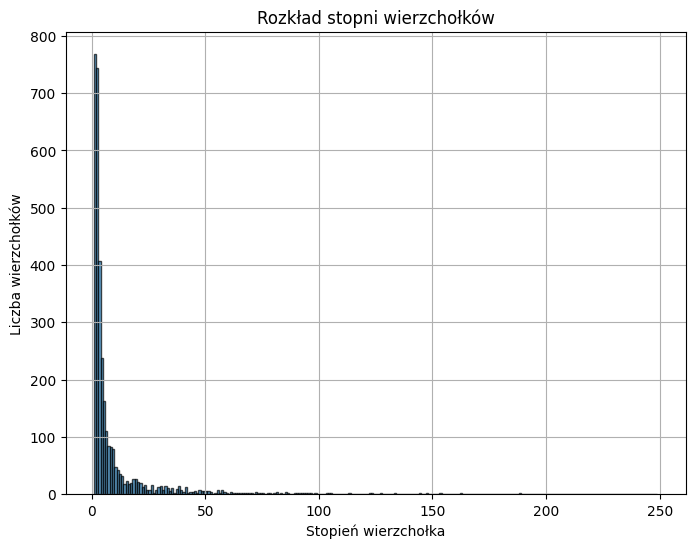

In [15]:
degrees = [graph_network.degree(n) for n in graph_network.nodes()]

plt.figure(figsize=(8, 6))
plt.hist(degrees, bins=range(min(degrees), max(degrees) + 2), edgecolor='black', alpha=0.7)
plt.title("Rozkład stopni wierzchołków")
plt.xlabel("Stopień wierzchołka")
plt.ylabel("Liczba wierzchołków")
plt.grid(True)
plt.show()

### Wykładnik rozkładu potęgowego metodą regresji dla dopełnienia dystrybuanty rozkładu stopni, dla przedziałów rozlokowanych logarytmicznie

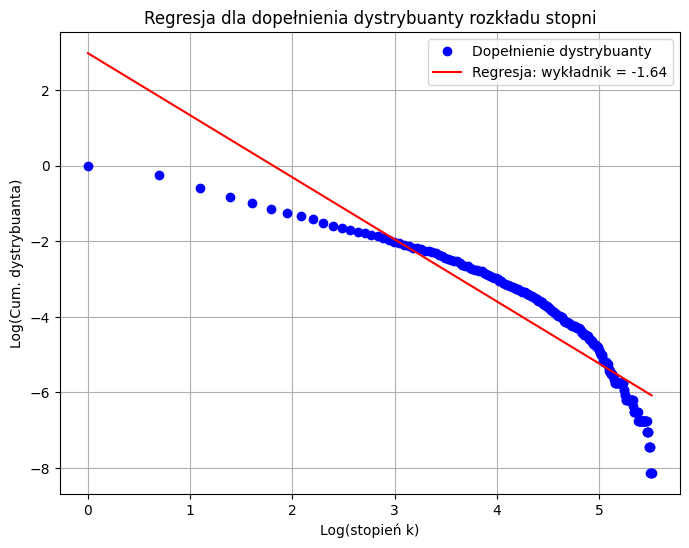

Wyznaczony wykładnik rozkładu potęgowego: -1.64


In [16]:
degrees = [graph_network.degree(n) for n in graph_network.nodes()]

degree_counts = np.bincount(degrees)
k_values = np.arange(len(degree_counts))  # stopnie k
cum_counts = np.cumsum(degree_counts[::-1])[::-1]  # dopełnienie dystrybuanty
cum_counts_normalized = cum_counts / float(len(degrees))

log_k = np.log(k_values[k_values > 0])  # bez log(0)
log_cum_counts = np.log(cum_counts_normalized[k_values > 0])

slope, intercept, r_value, p_value, std_err = st.linregress(log_k, log_cum_counts)

plt.figure(figsize=(8, 6))
plt.plot(log_k, log_cum_counts, 'bo', label="Dopełnienie dystrybuanty")
plt.plot(log_k, slope * log_k + intercept, 'r-', label=f"Regresja: wykładnik = {slope:.2f}")
plt.title("Regresja dla dopełnienia dystrybuanty rozkładu stopni")
plt.xlabel("Log(stopień k)")
plt.ylabel("Log(Cum. dystrybuanta)")
plt.legend()
plt.grid(True)
plt.show()

print(f"Wyznaczony wykładnik rozkładu potęgowego: {slope:.2f}")

### Wykres Hilla

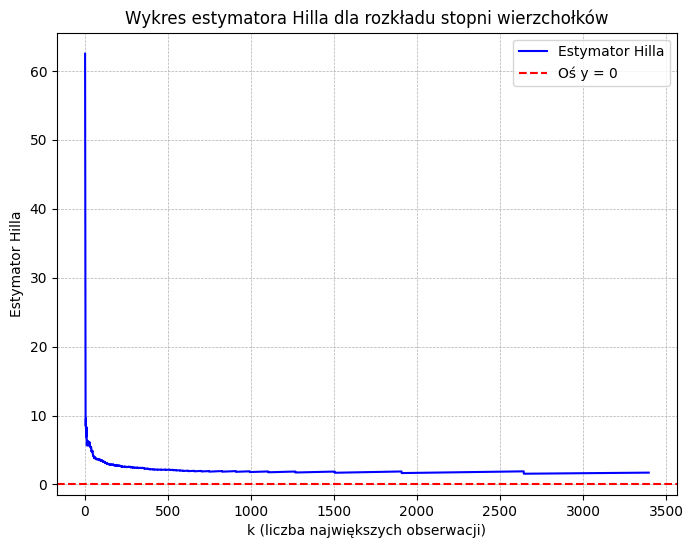

In [26]:
def hill_estimator(data, k):
    if k <= 0 or k >= len(data):
        raise ValueError(f"k [{k}] musi być w przedziale (0, {len(data)})")
    x_k = data[k]
    y_k = (1 / k) * sum(np.log(data[:k] / x_k))
    return 1 + pow(y_k, -1)


degree_sequence = np.array(sorted([d for _, d in largest_subgraph.degree()], reverse=True)) # posortowanie stopni wierzchołków malejąco
k_values = range(1, len(degree_sequence)) # wybór k (liczba największych obserwacji)

# obliczanie estymatora Hilla dla różnych wartości k
hill_values = [hill_estimator(degree_sequence, k) for k in k_values]

# rysowanie wykresu
plt.figure(figsize=(8, 6))
plt.plot(k_values, hill_values, 'b-', label="Estymator Hilla")
plt.xlabel("k (liczba największych obserwacji)")
plt.ylabel("Estymator Hilla")
plt.title("Wykres estymatora Hilla dla rozkładu stopni wierzchołków")
plt.axhline(y=0, color="red", linestyle="--", label="Oś y = 0")
plt.legend()
plt.grid(True, linestyle="--", linewidth=0.5)
plt.show()